# Transfer Learning Job Profiles

The following graphs and statistics capture the profile of the transfer learning experiments.

In [56]:
# NOTEBOOK VARIABLES

experiment = "sharded_1"
clusters_file = "clusters_pck6.csv"

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

dir_prefix = "experiment_data/job_profiles"

clusters_df = pd.read_csv(f"{dir_prefix}/clusters_pck6.csv", header=0).sort_values(by="cluster_id")
cluster_models_stats_df = pd.read_csv(f"{dir_prefix}/cluster_model_stats_{experiment}.csv", header=0).sort_values(by="cluster_id")
centroid_models_stats_df = pd.read_csv(f"{dir_prefix}/centroid_stats_{experiment}.csv", header=0).sort_values(by="cluster_id")
sequential_model_stats_df = pd.read_csv(f"{dir_prefix}/sequential_stats.csv", header=0).sort_values(by="cluster_id")
sequential_tasks_df = pd.read_csv(f"{dir_prefix}/experiment_profile_sequential.csv", header=1)
transfer_learn_tasks_df = pd.read_csv(f"{dir_prefix}/experiment_profile_{experiment}.csv", header=1)

centroid_models_stats_df

,gis_join,cluster_id,number_records,time_ms,rmse,iterations,best_reg_param,best_tolerance,best_epsilon
26,G1800570,0,2160,821370,6.614908,2,0.0,0.001,1.35
11,G1300950,1,2520,821158,7.511312,2,0.0,0.001,1.35
47,G4900010,2,17280,824595,4.761166,2,0.0,0.001,1.35
18,G4800790,3,5760,821326,5.971569,3,0.0,0.001,1.35
38,G3600710,4,5400,823396,6.476093,2,0.0,0.001,1.35
23,G3701310,5,3240,820962,7.716109,2,0.0,0.001,1.35
2,G1200090,6,6120,818796,7.634914,2,0.0,0.001,1.35
16,G2001090,7,6480,821192,6.487613,3,0.0,0.001,1.35
45,G4100650,8,16920,824327,3.707888,3,0.0,0.001,1.35
3,G3700210,9,4320,819033,7.059683,2,0.1,0.001,1.35


In [3]:
def human_time(difference_ms):
    return datetime.timedelta(milliseconds=difference_ms)

class Cluster:
    
    def __init__(self, cluster_id):
        self.id = cluster_id
        self.gis_joins = []
        self.center_gis_join = ""
        self.records_count = 0
        

class Task:
    
    def __init__(self, task_id, name, begin, end, time_seconds, gis_join="", cluster_id=-1):
        self.id = task_id
        self.name = name
        self.begin = begin
        self.end = end
        self.time_seconds = time_seconds
        self.gis_join = gis_join
        self.cluster_id = cluster_id
        
    def __repr__(self):
        return repr(f"Task: id={self.id}, name={self.name}, begin={self.begin}, end={self.end}, time_seconds={self.time_seconds}")
    
    
class CentroidModelTasks:
    
    def __init__(self):
        self.run_tasks = []
        
        
class ClusterLRModelTasks:
    
    def __init__(self):
        self.run_tasks = {}
        self.persist_tasks = {}
        self.train_all_tasks = {}
        self.train_tasks = {}


In [4]:
transfer_learn_experiment_task = None # Overarching task for experiment
sequential_experiment_task = None # Overarching task for experiment

centroid_model_tasks = CentroidModelTasks() # Tasks for centroid model training
transfer_learn_cluster_tasks = ClusterLRModelTasks() # Tasks for transfer-learned cluster training
sequential_cluster_tasks = ClusterLRModelTasks() # Tasks for sequential cluster training

clusters_pca = {} # Stats about cluster
clusters_seq = {} # Stats about cluster

In [10]:
# ----- Transfer Learn Tasks -----

for i, row in transfer_learn_tasks_df.iterrows():
    if (i == 0):
        transfer_learn_experiment_task = Task(i, row["name"], row["begin"], row["end"], row["time_seconds"])
    else:
        parts = row["name"].split(";")
        task_type = parts[0]
        task_name = parts[1]
        task_gis_join = parts[2][len("gisJoin=")+1:]
        task_cluster_id = str(parts[3][len("clusterId="):])

        new_task = Task(i, task_name, row["begin"], row["end"], row["time_seconds"], 
                        gis_join=task_gis_join, cluster_id=task_cluster_id)

        if (task_type == "CentroidModel"):

            if ("run()" in task_name):
                centroid_model_tasks.run_tasks.append(new_task)


        elif (task_type == "ClusterLRModels"):

            if ("run()" in task_name):

                if task_cluster_id not in transfer_learn_cluster_tasks.run_tasks:
                    transfer_learn_cluster_tasks.run_tasks[task_cluster_id] = [new_task]
                else:
                    transfer_learn_cluster_tasks.run_tasks[task_cluster_id].append(new_task)

            elif ("Cluster" in task_name):

                if task_cluster_id not in transfer_learn_cluster_tasks.persist_tasks:
                    transfer_learn_cluster_tasks.persist_tasks[task_cluster_id] = [new_task]
                else:
                    transfer_learn_cluster_tasks.persist_tasks[task_cluster_id].append(new_task)

            elif ("Train all" in task_name):

                if task_cluster_id not in transfer_learn_cluster_tasks.train_all_tasks:
                    transfer_learn_cluster_tasks.train_all_tasks[task_cluster_id] = [new_task]
                else:
                    transfer_learn_cluster_tasks.train_all_tasks[task_cluster_id].append(new_task)

            elif ("train()" in task_name):

                if task_cluster_id not in transfer_learn_cluster_tasks.train_tasks:
                    transfer_learn_cluster_tasks.train_tasks[task_cluster_id] = [new_task]
                else:
                    transfer_learn_cluster_tasks.train_tasks[task_cluster_id].append(new_task)

# ----- Sequential Tasks -----
    
for i, row in sequential_tasks_df.iterrows():
    if (i == 0):
        sequential_experiment_task = Task(i, row["name"], row["begin"], row["end"], row["time_seconds"])
    else:
        parts = row["name"].split(";")
        task_type = parts[0]
        task_name = parts[1]
        task_gis_join = parts[2][len("gisJoin=")+1:]
        cluster_id = int(parts[3][len("clusterId="):])
        task_cluster_id = str(cluster_id)

        new_task = Task(i, task_name, row["begin"], row["end"], row["time_seconds"], 
                        gis_join=task_gis_join, cluster_id=task_cluster_id)


        if (task_type == "ClusterLRModels"):

            if ("run()" in task_name):

                if task_cluster_id not in sequential_cluster_tasks.run_tasks:
                    sequential_cluster_tasks.run_tasks[task_cluster_id] = [new_task]
                else:
                    sequential_cluster_tasks.run_tasks[task_cluster_id].append(new_task)

            elif ("Cluster" in task_name):

                if task_cluster_id not in sequential_cluster_tasks.persist_tasks:
                    sequential_cluster_tasks.persist_tasks[task_cluster_id] = [new_task]
                else:
                    sequential_cluster_tasks.persist_tasks[task_cluster_id].append(new_task)

            elif ("Train all" in task_name):
                
                numRecords = int(parts[5][len("numRecords="):])
                #print(cluster_id)
                clusters_seq[cluster_id] = Cluster(cluster_id)
                clusters_seq[cluster_id].records_count = numRecords
                #print(numRecords)
                
                if task_cluster_id not in sequential_cluster_tasks.train_all_tasks:
                    sequential_cluster_tasks.train_all_tasks[task_cluster_id] = [new_task]
                else:
                    sequential_cluster_tasks.train_all_tasks[task_cluster_id].append(new_task)

            elif ("train()" in task_name):

                if task_cluster_id not in sequential_cluster_tasks.train_tasks:
                    sequential_cluster_tasks.train_tasks[task_cluster_id] = [new_task]
                else:
                    sequential_cluster_tasks.train_tasks[task_cluster_id].append(new_task)
                    
                    
# ----- PCA Clusters -----
    
for i, row in clusters_df.iterrows():
    cluster_id = row["cluster_id"]
    if cluster_id not in clusters_pca:
        clusters_pca[cluster_id] = Cluster(cluster_id)
    
    if row["is_center"]:
        clusters_pca[cluster_id].center_gis_join = row["gis_join"]
    else:
        clusters_pca[cluster_id].gis_joins.append(row["gis_join"])
        
# ----- Seq Clusters -----
    
for i, row in sequential_model_stats_df.iterrows():
    cluster_id = row["cluster_id"]
    clusters_seq[cluster_id].gis_joins.append(row["gis_join"])
        

In [6]:
len(clusters_seq[0].gis_joins)

55

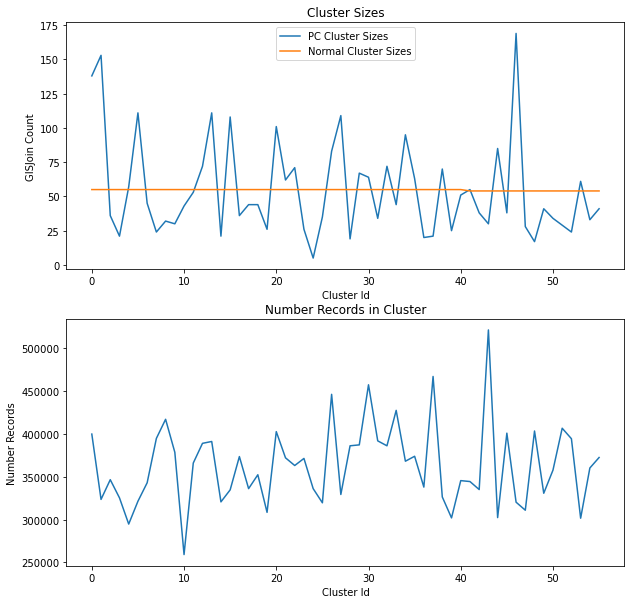

In [9]:
# ---- Plot Clusters Bar Chart -----

transfer_learning_cluster_sizes = []
sequential_cluster_sizes = []
sequential_cluster_numrecords = []

for i in range(0,56):
    transfer_learning_cluster_sizes.append(len(clusters_pca[i].gis_joins)+1)
    sequential_cluster_sizes.append(len(clusters_seq[i].gis_joins))
    sequential_cluster_numrecords.append(clusters_seq[i].records_count)

    
    # Create a figure
figure, axis = plt.subplots(2, 1, figsize=(10,10))

# For Iterations
axis[0].plot(range(0, 56), transfer_learning_cluster_sizes, label="PC Cluster Sizes")
axis[0].plot(range(0, 56), sequential_cluster_sizes, label="Normal Cluster Sizes")
axis[0].legend()
axis[0].set_title("Cluster Sizes")
axis[0].set_ylabel("GISJoin Count")
axis[0].set_xlabel("Cluster Id")

axis[1].plot(sequential_cluster_numrecords, label="Normal Cluster Records")
axis[1].set_title("Number Records in Cluster")
axis[1].set_ylabel("Number Records")
axis[1].set_xlabel("Cluster Id")

plt.show()

Experiment sharded_1 Time: 1971.22 seconds
Total time taken to train/evaluate 56 centroid models: 0:14:10.356000


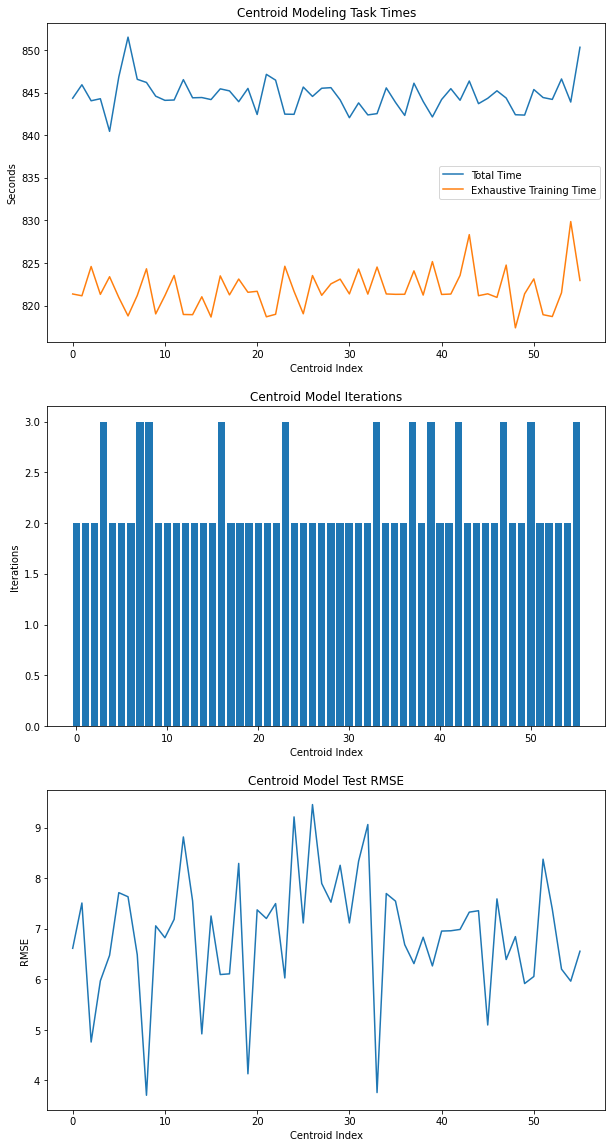

In [11]:
# ---- Centroid Models Plotting -----

centroid_run_tasks = []
for i in range(0,56):
    run_task = centroid_model_tasks.run_tasks[i]
    centroid_run_tasks.append(run_task.time_seconds)


total_centroid_time = human_time(centroid_model_tasks.run_tasks[-1].end 
                                 - centroid_model_tasks.run_tasks[0].begin)

total_experiment_time = transfer_learn_experiment_task.time_seconds

print("Experiment %s Time: %s seconds" % (experiment, total_experiment_time))
print("Total time taken to train/evaluate 56 centroid models:", total_centroid_time)



# Create a figure
figure, axis = plt.subplots(3, 1, figsize=(10,20))


# For Centroid Task Times
axis[0].plot(centroid_run_tasks, label="Total Time")
axis[0].plot((centroid_models_stats_df["time_ms"]/1000.0).to_list(), label="Exhaustive Training Time")
axis[0].set_title("Centroid Modeling Task Times")
axis[0].set_ylabel("Seconds")
axis[0].set_xlabel("Centroid Index")
axis[0].legend()

# For Iterations
axis[1].bar(range(0, 56),centroid_models_stats_df["iterations"].to_list())
axis[1].set_title("Centroid Model Iterations")
axis[1].set_ylabel("Iterations")
axis[1].set_xlabel("Centroid Index")


# For RMSE
axis[2].plot(centroid_models_stats_df["rmse"].to_list())
axis[2].set_title("Centroid Model Test RMSE")
axis[2].set_ylabel("RMSE")
axis[2].set_xlabel("Centroid Index")

# show plot
plt.show()

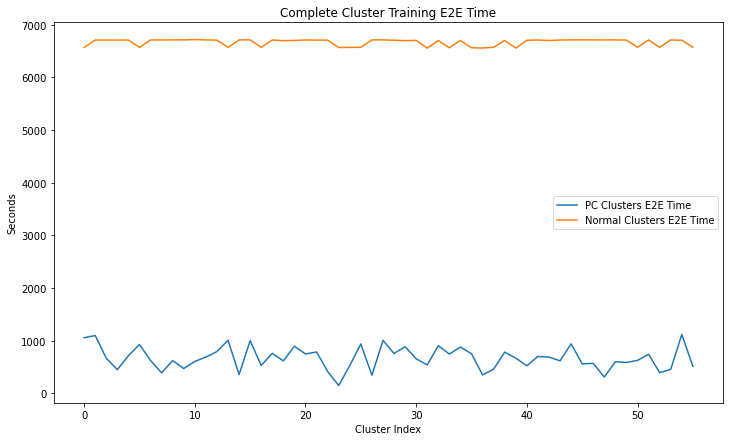

In [12]:
# ---- Cluster Transfer Learning Model Plotting -----

clusters_run_time_seconds = [val[0].time_seconds for val in transfer_learn_cluster_tasks.run_tasks.values()]
seq_clusters_run_time_seconds = [val[0].time_seconds for val in sequential_cluster_tasks.run_tasks.values()]


# Create a figure
plt.figure(figsize=(12,7))

# For Cluster Training End-to-End Time
plt.plot(clusters_run_time_seconds, label="PC Clusters E2E Time")
plt.plot(seq_clusters_run_time_seconds, label="Normal Clusters E2E Time")
plt.title("Complete Cluster Training E2E Time")
plt.ylabel("Seconds")
plt.xlabel("Cluster Index")
plt.legend()

plt.show()

In [47]:
# ---- Cluster Model Plotting -----

cluster_models_stats_df
centroid_models_stats_df
sequential_model_stats_df

times_ms    = [[],[]]
iterations  = [[],[]]
num_records = [[],[]]


for i, seq_row in sequential_model_stats_df.iterrows():
    gis_join = seq_row["gis_join"]
    
    times_ms[0].append(seq_row["time_ms"]/1000.0)
    iterations[0].append(seq_row["iterations"])
    num_records[0].append(seq_row["num_records"])
    
    search_df = cluster_models_stats_df.loc[ cluster_models_stats_df["gis_join"] == gis_join ]
    if search_df.size > 0:
        row = search_df.iloc[0]
        times_ms[1].append(row["time_ms"]/1000.0)
        iterations[1].append(row["iterations"])
    else: # Centroid model
        search_df = centroid_models_stats_df.loc[ centroid_models_stats_df["gis_join"] == gis_join ]
        times_ms[1].append(0)
        iterations[1].append(search_df.iloc[0]["iterations"])
        
    

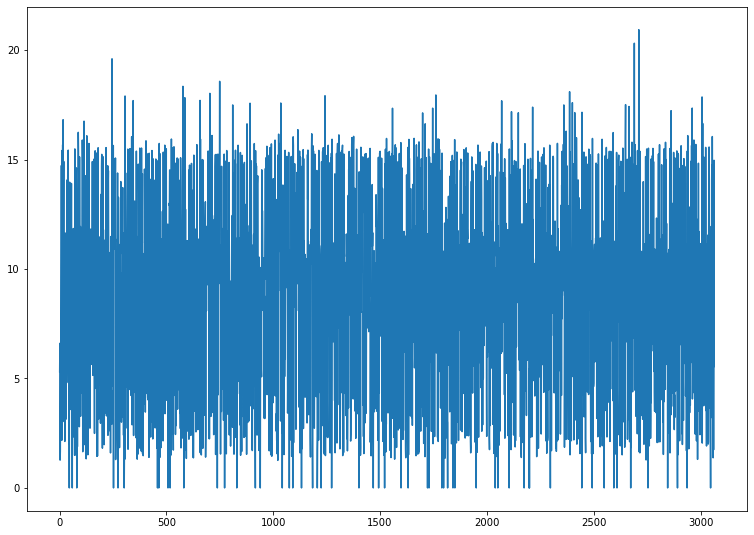

In [61]:
fig = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
  
# Creating plot
#ax.plot(times_ms[0])
ax.plot(times_ms[1])
#bp = ax.boxplot(times_ms)

plt.show()

In [ ]:
import numpy as np
gis_join_df = pd.read_csv("experiment_data/rows.csv", header=0)

X1 = gis_join_df["relative_humidity_percent"].to_list()
Y1 = gis_join_df["label"].to_list()

X2 = np.linspace(0, 100, 100)
Y2 = -0.13438541379122257 * X2 + 281.6580

plt.figure(figsize=(15,7))
plt.plot(X1,Y1, "ro")
plt.plot(X2,Y2, "g-")
plt.xlabel("Relative Humidity Percent")
plt.ylabel("Temperature Kelvin")
plt.show()